#### <b>필요한 라이브러리 설치</b>

In [1]:
# # 트랜스포머 라이브러리 설치(Huggig Face에 있는 모델 불러오기 가능)
# !pip install transformers
# !pip install datasets # 데이터 세트 다운로드 Hugging Face와 연동

#### <b>필요한 라이브러리 불러오기</b>

In [74]:
import copy 
import json
import logging 
import os 

import warnings
warnings.filterwarnings("ignore")
import logging
logging.basicConfig(level=logging.ERROR)

import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch

In [75]:
import torch

# GPU 사용 가능 여부 확인
print("CUDA Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    # 현재 활성화된 GPU 인덱스 확인
    print("Current GPU Index:", torch.cuda.current_device())
    
    # 현재 활성화된 GPU의 이름 확인
    print("Current GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    
    # GPU 메모리 사용량 확인
    print("GPU Memory Allocated:", torch.cuda.memory_allocated())
    print("GPU Memory Cached:", torch.cuda.memory_cached())

CUDA Available: True
Current GPU Index: 0
Current GPU Name: GeForce RTX 2080 Ti
GPU Memory Allocated: 1885709312
GPU Memory Cached: 5186256896


#### <b>학습할 모델 관련 라이브러리 불러오기</b>

* <b>Hugging Face Auto Class</b>
  * <b>Auto 키워드</b>: 사전 학습된(pre-trained) 모델을 이용해 원하는 작업을 수행한다.
    * → 최대한 자동화할 수 있게 만들어진 라이브러리
    * <b>AutoTokenizer</b>: 입력을 토큰(token)으로 바꾸는 기능을 수행한다.
사전 학습된 tokenizer를 불러올 수 있다.
    * <b>AutoModelForSequenceClassification</b>: 문장 분류(classification)을 위한 자동화된 모델을 제공한다.
      * forward() 함수 자체가 사전에 설정한 num_classes와 일치
      * 만약 우리가 multi-task learning을 한다면, 이걸 그대로 사용하기는 어렵다.
    * 만약 multi-task learning을 하는 상황에서는 대신에 <b>AutoModel</b>을 이용해서 직접 수정하는 것이 효과적
    * <b>AutoModel</b>: 꼭 텍스트 분류 목적이 아니라, BERT 등의 모델을 불러올 수 있도록
  * 사전 학습된 BERT 모델을 불러올 수 있다.
    * 예시) bert-base-multilingual-sentiment
  * from_pretrained() 함수를 이용해 특정한 경로에서 모델을 불러올 수 있다.
  * PyTorch 혹은 TensorFlow 상관없이 사용할 수 있다.

In [8]:
import transformers
# Auto Model For Sequence Classification: 텍스트 분류를 위한 모델 → Cross-Entropy loss 사용
from transformers import AutoConfig, AutoModel, AutoModelForSequenceClassification, AutoTokenizer
# linear_schedule_with_warmup: 단계적으로 learning rate 줄여나가는 방법
from transformers import AdamW, get_linear_schedule_with_warmup

#### <b>본 실습에서 어떤 모델을 쓸 것인가?</b>

* KoBigBird를 사용하고, 다음과 같은 형태로 사용 가능
  * KoBigBird: BigBird 특유의 sparse attention 사용 (default)

<pre>
from transformers import AutoModel, AutoTokenizer

# by default its in `block_sparse` mode with num_random_blocks=3, block_size=64
model = AutoModel.from_pretrained("monologg/kobigbird-bert-base")

# you can change `attention_type` to full attention like this:
model = AutoModel.from_pretrained("monologg/kobigbird-bert-base", attention_type="original_full")

# you can change `block_size` & `num_random_blocks` like this:
model = AutoModel.from_pretrained("monologg/kobigbird-bert-base", block_size=16, num_random_blocks=2)

tokenizer = AutoTokenizer.from_pretrained("monologg/kobigbird-bert-base")
text = "한국어 BigBird 모델을 공개합니다!"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
</pre>

In [9]:
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("monologg/kobigbird-bert-base")

tokenizer = AutoTokenizer.from_pretrained("monologg/kobigbird-bert-base")
text = "한국어 BigBird 모델을 공개합니다!"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

Attention type 'block_sparse' is not possible if sequence_length: 12 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


In [10]:
print(encoded_input)

{'input_ids': tensor([[    2, 11802, 32418,  4616,  9101,  4565,  7498,  4604,  7220, 15763,
           505,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [11]:
print(output.last_hidden_state.shape)
# 각 데이터마다 [CLS] 토큰만 가져오기
print(output.last_hidden_state[:,0,:].shape)

torch.Size([1, 12, 768])
torch.Size([1, 768])


In [12]:
# 기초 설정상 last_hidden_state와 pooler_output만 출력
print(output.last_hidden_state[0][0][:10]) # 마지막 레이어 hidden_states에서 [CLS] 토큰 임베딩
print(output.pooler_output[0][:10]) # 마지막 레이어 hidden_states에서 [CLS] 토큰 임베딩에 추가적인 처리를 거친 결과

tensor([ 0.0744,  0.1033, -0.4811,  0.0936, -0.2172, -0.2245, -0.3635, -0.5025,
         0.3230,  0.1951], grad_fn=<SliceBackward0>)
tensor([ 0.4389, -0.4116, -0.1959, -0.0865, -0.2311,  0.3522, -0.1873, -0.1011,
         0.3908, -0.4379], grad_fn=<SliceBackward0>)


#### <b>실험을 위한 하이퍼 파라미터 설정</b>

In [123]:
# SimpleNamespace는 온점(.)으로 속성의 값을 정의할 수 있도록 해주는 라이브러리
# config.task = "cls"라고 하면, 나중에 print(config.task)했을 때 "cls"라고 출력
from types import SimpleNamespace

config = SimpleNamespace()

config.task = "cls"
config.dataset = "comment"

config.cache_dir = "cache" # 현재 데이터 세트에 대한 단어집 등 현재 task를 위한 임시적인 폴더
config.output_dir = "output" # 최종적인 모델이 저장되고, 결과가 저장되는 폴더

config.use_tpu = False
config.model_name_or_path = "monologg/kobigbird-bert-base" # Model name or path (HuggingFace에서 불러와 사용할 모델 이름)
config.data_dir = "./" # The input data dir ("10000_labeled.csv"가 있는 경로)

config.train_file = "10000_labeled.csv" 
config.predict_file = "10000_labeled.csv" # → 나중에 생기면 갈아끼우기

config.max_seq_length = 1024 
config.train_batch_size = 4 # Batch size for training. (학습할 때 batch_size)
config.eval_batch_size = 2 # Batch size for evaluation. (평가할 때 batch_size)

config.learning_rate = 3e-5 # The initial learning rate for Adam. (Adam optimizer에서 쓸 learning rate)
config.num_train_epochs = 10 # Total number of training epochs to perform. (전체 학습 epoch 수)

# config.preference_classes = 5
# config.slang_classes = 1
# config.politic_classes = 1
config.gradient_accumulation_steps = 2 # Number of updates steps to accumulate before performing a backward/update pass.
# batch_size가 큰 것처럼 처리하기 위해서, backward()를 매 번 수행하지 않고, gradient를 누적(acculmulation)하는 것

config.threads = 4
config.seed = 42 

config.do_train = True 
config.do_eval_during_train = True
config.do_eval = True 

config.do_lower_case = False
config.weight_decay = 0.0 # Weight decay if we apply some.
config.adam_epsilon = 1e-8 # Epsilon for Adam optimizer.
config.max_grad_norm = 1.0 # Max gradient norm.
config.warmup_proportion = 0.0 # Warmup proportion for linear warmup

#### <b>학습 데이터 전처리</b>

* 학습 텍스트를 매번 tokenizing을 하지 않고, <b>모델 학습 시작 전에 미리 모든 텍스트를 tokenizing</b> 한 결과를 저장한다.
  * 이렇게 했을 때, 결과적인 속도는 훨씬 빠르기 때문이다.

In [124]:
# 본 실습에서 사용할 tokenizer 객체 초기화
tokenizer = AutoTokenizer.from_pretrained(config.model_name_or_path, cache_dir=config.cache_dir)

In [136]:
def train_split(config, texts, labels, is_train):
    x_train, y_train, x_label, y_label = train_test_split(
        texts, labels, test_size=0.2, random_state=config.seed, stratify=None
    )
    if is_train:
        texts, labels = x_train, x_label
    else:
        texts, labels = y_train, y_label
    return texts, labels

def process_comment_cls(config, data_file, is_train):
    df = pd.read_csv(data_file)
    df = df.fillna(0)  # nan값 0으로 채우기
    df = df[df["선호도"]!= -1] # 선호도 -1 인 문장 학습에서 배제
    df = df[:500]
    preferences = df["선호도"].astype(int).values.tolist()
    slangs = df["비속어"].astype(int).values.tolist()
    politics = df["정치"].astype(int).values.tolist()
    labels = []
    for i in range(len(preferences)):
        preference = preferences[i] # 선호도
        slang = slangs[i] # 비속어
        politic = politics[i] # 정치
        labels.append([preference, slang, politic])
    texts = df["comment"].astype(str).values.tolist()
    texts, labels = train_split(config, texts, labels, is_train)
    return texts, labels

In [137]:
import torch.utils.data as torch_data

def data_pretokenizing(config, tokenizer, is_train=True):
    if is_train:
        data_file = config.train_file
    else:
        data_file = config.predict_file

    data_path = config.data_dir
    if data_file is not None:
        data_path = os.path.join(data_path, data_file)
    else:
        data_path += "/"

    # 실제로 tokenizer를  저장될 데이터 세트의 파일 이름이 바로 dataset_file
    comps = [
        data_path,
        config.dataset,
        config.model_name_or_path.replace("/", "_"),
        config.max_seq_length,
        "train" if is_train else "dev",
        "dataset.txt",
    ]
    dataset_file = "_".join([str(comp) for comp in comps])
    print("dataset_file:", dataset_file)

    # 기존에 write_samples() 함수가 하는 역할: 텍스트 문장을 읽어와서 token 값만 저장
    # 멀티 쓰레드 방식으로 구현되어 있어서, 더 (비효율적이지만) 이해하기 쉬운 코드로 돌려 놓음
    with open(dataset_file, "w", encoding="utf-8") as writer_file:
        # data: "10000_labeled.csv" 파일에서 읽어와 (텍스트, 선호도 레이블)만 남긴 .csv 파일
        cnt = 0
        total_data = process_comment_cls(config, data_path, is_train)
        for text, label in zip(total_data[0], total_data[1]):
            feature = tokenizer(text, max_length=config.max_seq_length, padding="max_length", truncation=True, add_special_tokens=True)
            writed_data = {
                "input_ids": feature["input_ids"],
                "attention_mask": feature["attention_mask"],
                "preference": int(label[0]), 
                "slang": int(label[1]),
                "politic": int(label[2]), 
            }
            writer_file.write(json.dumps(writed_data) + "\n")
            cnt += 1
        print(f"{cnt} features processed from {data_path}")

    return dataset_file

In [138]:
if config.do_train:
    # 학습 데이터 세트 전처리
    train_dataset_file = data_pretokenizing(config, tokenizer=tokenizer)

# 평가 데이터 세트 전처리(validation = dev 같은 의미)
predict_dataset_file = data_pretokenizing(config, tokenizer=tokenizer, is_train=False)

dataset_file: ./10000_labeled.csv_comment_monologg_kobigbird-bert-base_1024_train_dataset.txt
400 features processed from ./10000_labeled.csv
dataset_file: ./10000_labeled.csv_comment_monologg_kobigbird-bert-base_1024_dev_dataset.txt
100 features processed from ./10000_labeled.csv


#### <b>데이터 로더 초기화</b>

In [139]:
class IterableDatasetPad(torch.utils.data.IterableDataset):
    def __init__(
        self,
        dataset: torch.utils.data.IterableDataset,
        batch_size: int = 1,
        num_devices: int = 1,
        seed: int = 0,
    ):
        self.dataset = dataset
        self.batch_size = batch_size
        self.seed = seed
        self.num_examples = 0

        chunk_size = self.batch_size * num_devices
        length = len(dataset)
        self.length = length + (chunk_size - length % chunk_size)

    def __len__(self):
        return self.length

    def __iter__(self):
        self.num_examples = 0
        if (
            not hasattr(self.dataset, "set_epoch")
            and hasattr(self.dataset, "generator")
            and isinstance(self.dataset.generator, torch.Generator)
        ):
            self.dataset.generator.manual_seed(self.seed + self.epoch)

        first_batch = None
        current_batch = []
        for element in self.dataset:
            self.num_examples += 1
            current_batch.append(element)
            # Wait to have a full batch before yielding elements.
            if len(current_batch) == self.batch_size:
                for batch in current_batch:
                    yield batch
                    if first_batch is None:
                        first_batch = batch.copy()
                current_batch = []

        while self.num_examples < self.length:
            add_num = self.batch_size - len(current_batch)
            self.num_examples += add_num
            current_batch += [first_batch] * add_num
            for batch in current_batch:
                yield batch
            current_batch = []

In [140]:
def collate_fn(features):
    input_ids = [sample["input_ids"] for sample in features]
    attention_mask = [sample["attention_mask"] for sample in features]
    
    preference = [sample["preference"] for sample in features]
    slang = [sample["slang"] for sample in features]
    politic = [sample["politic"] for sample in features]

    input_ids = torch.tensor(np.array(input_ids).astype(np.int64), dtype=torch.long)
    attention_mask = torch.tensor(np.array(attention_mask).astype(np.int8), dtype=torch.long)
    
    preference = torch.tensor(np.array(preference).astype(np.int64), dtype=torch.long)
    slang = torch.tensor(np.array(slang).astype(np.int64), dtype=torch.float)
    politic = torch.tensor(np.array(politic).astype(np.int64), dtype=torch.float)
    inputs = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
    }
    labels = {
        "preference": preference,
        "slang": slang,
        "politic": politic
    }
    return inputs, labels

if config.do_train:
    train_dataset = load_dataset("text", data_files=train_dataset_file, download_mode="force_redownload")["train"]
    train_dataset = train_dataset.map(lambda x: json.loads(x["text"]), batched=False)

    train_dataloader = torch_data.DataLoader(
        train_dataset,
        sampler=torch_data.RandomSampler(train_dataset),
        drop_last=False,
        batch_size=config.train_batch_size,
        collate_fn=(collate_fn),
    )

predict_dataset = load_dataset("text", data_files=predict_dataset_file, download_mode="force_redownload")["train"]
predict_dataset = predict_dataset.map(lambda x: json.loads(x["text"]), batched=False)
predict_dataset = IterableDatasetPad(
    dataset=predict_dataset,
    batch_size=config.eval_batch_size,
    num_devices=1,
    seed=config.seed,
)

predict_dataloader = torch_data.DataLoader(
    predict_dataset,
    sampler=None,
    drop_last=False,
    batch_size=config.eval_batch_size,
    collate_fn=(collate_fn),
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

#### <b>텍스트 분류 모델 정의</b>

In [141]:
from transformers import AutoModel
import torch.nn as nn

class ClsModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        data_file = os.path.join(config.data_dir, str(config.train_file))  # (전처리된) 학습할 데이터 세트의 경로 설정
        model_config = AutoConfig.from_pretrained(config.model_name_or_path, num_labels=5)
        self.model = AutoModel.from_pretrained(
            config.model_name_or_path, config=model_config, cache_dir=config.cache_dir
        )
        self.classifier1 = nn.Linear(768, 5) # 선호도 분류기
        self.classifier2 = nn.Linear(768, 1) # 비속어 분류기
        self.classifier3 = nn.Linear(768, 1) # 정치 편향 분류기

        self.tokenizer = tokenizer

    def save_pretrained(self, save_dir):
        self.model.save_pretrained(save_dir)
        for key in ["special_tokens_map_file", "tokenizer_file"]:
            self.tokenizer.init_kwargs.pop(key, None)
        self.tokenizer.save_pretrained(save_dir)

    def get_optimizer(self): # 현재 모델을 학습하기 위한 최적화 방법(AdamW) 객체를 불러오는 함수
        # bias랑 LayerNorm에는 decay 적용하지 않겠다는 의미
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": config.weight_decay,
            },
            {
                "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": config.weight_decay,
            },
        ]
        
        optimizer = AdamW(optimizer_grouped_parameters, lr=config.learning_rate, eps=config.adam_epsilon)
        return optimizer

    def get_scheduler(self, batch_num, optimizer): 
        if config.warmup_proportion == 0.0:
            return None

        t_total = batch_num // config.gradient_accumulation_steps * config.num_train_epochs

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(t_total * config.warmup_proportion),
            num_training_steps=t_total,
        )

        return scheduler

    def forward(self, inputs):
        hidden = self.model(**inputs)
        # 마지막 레이어의 [CLS] 토큰만 가져오기
        cls_token_embeddings = hidden.last_hidden_state[:,0,:] # [batch_size, 768]
        output_1 = self.classifier1(cls_token_embeddings) # 768 → 5
        output_2 = torch.sigmoid(self.classifier2(cls_token_embeddings)) # 768 → 1
        output_3 = torch.sigmoid(self.classifier3(cls_token_embeddings)) # 768 → 1

        return output_1, output_2, output_3
    

    def eval_step(self, inputs, labels, outputs):
        logits_1 = outputs[0].detach().cpu()
        logits_2 = outputs[1].detach().cpu()
        logits_3 = outputs[2].detach().cpu()
        labels_1 = self.tensor_to_list(labels["preference"])
        labels_2 = self.tensor_to_list(labels["slang"])
        labels_3 = self.tensor_to_list(labels["politic"])
        threshold = 0.5
        predictions_1 = self.tensor_to_list(torch.argmax(logits_1, dim=-1))
        predictions_2 = self.tensor_to_list(logits_2.squeeze(1) >= threshold)
        predictions_3 = self.tensor_to_list(logits_3.squeeze(1) >= threshold)
        results_1 = [{"prediction": prediction, "label": label} for prediction, label in zip(predictions_1, labels_1)]
        results_2 = [{"prediction": prediction, "label": label} for prediction, label in zip(predictions_2, labels_2)]
        results_3 = [{"prediction": prediction, "label": label} for prediction, label in zip(predictions_3, labels_3)]
        
        return {"results_1": results_1, "results_2": results_2, "results_3": results_3}

    def tensor_to_array(self, tensor):
        return tensor.detach().cpu().numpy()
    
    def tensor_to_list(self, tensor):
        return self.tensor_to_array(tensor).tolist()

In [142]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def cal_running_avg_loss(loss, running_avg_loss, decay=0.99):
    if running_avg_loss == 0:
        return loss
    running_avg_loss = running_avg_loss * decay + (1 - decay) * loss
    return running_avg_loss

#### <b>모델 학습 및 평가 라이브러리</b>

In [143]:
from functools import partial
import sklearn.metrics as sklearn_metrics

# for binary-classification
binary_metrics = {
    "accuracy": sklearn_metrics.accuracy_score,
    "precision": sklearn_metrics.precision_score, # TP / (TP + FP)
    "recall": sklearn_metrics.recall_score, # recall = sensitivity (민감도)
    "f1": sklearn_metrics.f1_score,
    "matthews_corrcoef": sklearn_metrics.matthews_corrcoef,
    "roc_auc": sklearn_metrics.roc_auc_score,
}

# for multi-classification
metrics = {
    "accuracy": sklearn_metrics.accuracy_score,
    "f1-macro": partial(sklearn_metrics.f1_score, average="macro"),
}

def eval_cls(results_1, results_2, results_3, **kwargs):
    
    predictions_1 = np.array([result["prediction"] for result in results_1])
    labels_1 = np.array([result["label"] for result in results_1])
    predictions_2 = np.array([result["prediction"] for result in results_2])
    labels_2 = np.array([result["label"] for result in results_2])
    predictions_3 = np.array([result["prediction"] for result in results_3])
    labels_3 = np.array([result["label"] for result in results_3])

    results_1 = {
        metric: round(f(labels_1, predictions_1) * 100, 2)
        for metric, f in metrics.items()
    }
    results_2 = {
        metric: round(f(labels_2, predictions_2) * 100, 2)
        for metric, f in binary_metrics.items()
    }
    results_3 = {
        metric: round(f(labels_3, predictions_3) * 100, 2)
        for metric, f in binary_metrics.items()
    }
    
    print(f"results_1 : {results_1}")

    return {
        "results_1": results_1,
        "results_2": results_2,
        "results_3": results_3,
        "best_score_1": results_1["f1-macro"],
        "best_score_2": results_2["f1"],
        "best_score_3": results_3["f1"],
    }

In [144]:
# _run_epoch() 함수는, 우리가 흔히 알고있는 학습 함수와 동일
def _run_epoch(model, loader, device=None, context=None, **kwargs):
    config = kwargs["config"]
    is_train = kwargs["is_train"]

    avg_loss = 0
    results = []
    batch_num = len(loader)

    if is_train:
        model.train()
        if config.use_tpu:
            optimizer = context.getattr_or(
                "optimizer",
                lambda: model.get_optimizer(),
            )
            scheduler = context.getattr_or(
                "scheduler",
                lambda: model.get_scheduler(batch_num, optimizer),
            )
        else:
            optimizer = kwargs["optimizer"]
            scheduler = kwargs["scheduler"]
    else:
        model.eval()

    is_master = True

    pbar = tqdm(enumerate(loader), total=batch_num, disable=not is_master, dynamic_ncols=True, position=0, leave=True)

    corrected_1 = 0
    corrected_2 = 0
    corrected_3 = 0
    total = 0
    
    for i, (inputs, labels) in pbar:
        if not config.use_tpu:
            for k, v in inputs.items():
                if isinstance(v, torch.Tensor):
                    inputs[k] = v.to(device)
            for k, v in labels.items():
                if isinstance(v, torch.Tensor):
                    labels[k] = v.to(device)

        outputs = model(inputs)

        outputs_1 = outputs[0]
        outputs_2 = outputs[1]
        outputs_3 = outputs[2]

        labels_1 = labels["preference"]
        labels_2 = labels["slang"]
        labels_3 = labels["politic"]

        loss_function_1 = nn.CrossEntropyLoss()
        loss_1 = loss_function_1(outputs_1, labels_1) # 말 그대로 scalr (cuda)

        total += outputs_1.shape[0] # batch_size만큼 더해주기
        _, predicted1 = outputs_1.max(1)
        corrected_1 += predicted1.eq(labels_1).sum().item() 

        loss_function_2 = nn.BCELoss()
        loss_2 = loss_function_2(outputs_2.squeeze(1), labels_2)  # 말 그대로 scalr (cuda)
        threshold = 0.5
        predicted2 = outputs_2.squeeze(1) >= threshold
        corrected_2 += predicted2.eq(labels_2).sum().item()

        loss_function_3 = nn.BCELoss()
        loss_3 = loss_function_3(outputs_3.squeeze(1), labels_3)
        threshold = 0.5
        predicted3 = outputs_3.squeeze(1) >= threshold
        corrected_3 += predicted3.eq(labels_3).sum().item()

        #print(f"선호도 예측 학습 정확도: {corrected_1 / total}, 비속어 예측 학습 정확도: {corrected_2 / total}, 정치 예측 학습 정확도: {corrected_3 / total}")
        w_1 = 1
        w_2 = 1
        w_3 = 1
        loss = w_1 * loss_1 + w_2 * loss_2 + w_3 * loss_3

        avg_loss = cal_running_avg_loss(loss.item(), avg_loss)
        loss /= config.gradient_accumulation_steps

        if is_train:
            loss.backward()
            if i % config.gradient_accumulation_steps == 0 or i == batch_num - 1:
                if config.max_grad_norm > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

                optimizer.step()
                optimizer.zero_grad()

                if scheduler is not None:
                    scheduler.step()
        
        else:
            result = (model.module if hasattr(model, "module") else model).eval_step(inputs, labels, outputs)
            results.append(result)

        if is_master:
            pbar.set_description(
                f"epoch: {kwargs['epoch'] + 1}, {('train' if is_train else 'valid')} loss: {min(100, round(avg_loss, 4))}"
            )
    return {
        "loss": avg_loss,
        "result": results,
    }

def run_epoch(**kwargs):
    model = kwargs.pop("model")
    if kwargs["config"].use_tpu:
        results = model(_run_epoch, **kwargs)
    else:
        results = _run_epoch(model, **kwargs)
   
    if isinstance(results, list):
        loss = sum([result["loss"] for result in results]) / len(results)
        result = []
        for res in results:
            result.extend(res["result"])
        results = {"loss": loss, "result": result}

    return results

#### <b>딥러닝 모델 초기화 및 설정</b>

In [145]:
set_seed(config.seed)

model = ClsModel()  # 딥러닝 모델 초기화

print(f"configuration: {str(config)}")

if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"{gpu_count} GPU device detected")
    devices = ["cuda:{}".format(i) for i in range(gpu_count)]
    model_dp = torch.nn.DataParallel(model, device_ids=devices)
    model_dp.to(devices[0])  #GPU 병렬처리
    #model.to(devices[0])
else: 
    devices = ["cpu"]
    model_dp = model

if not os.path.exists(config.cache_dir):
    os.makedirs(config.cache_dir)

output_dir = os.path.join(config.output_dir, config.task, config.dataset)
print("Output directory:", output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

optimizer = None
scheduler = None
if config.do_train: # 학습 모드(train mode)인 경우
    optimizer = model.get_optimizer()
    scheduler = model.get_scheduler(len(train_dataloader), optimizer)

params = {
    "config": config,
    "model": model_dp,
    "optimizer": optimizer,
    "scheduler": scheduler,
}
if not config.use_tpu:
    params["device"] = devices[0]

configuration: namespace(task='cls', dataset='comment', cache_dir='cache', output_dir='output', use_tpu=False, model_name_or_path='monologg/kobigbird-bert-base', data_dir='./', train_file='10000_labeled.csv', predict_file='10000_labeled.csv', max_seq_length=1024, train_batch_size=4, eval_batch_size=2, learning_rate=3e-05, num_train_epochs=10, gradient_accumulation_steps=2, threads=4, seed=42, do_train=True, do_eval_during_train=True, do_eval=True, do_lower_case=False, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, warmup_proportion=0.0)
4 GPU device detected
Output directory: output/cls/comment


#### 모델 학습하기

In [146]:
def do_eval(epoch):
    with torch.no_grad():
        results = run_epoch(loader=predict_dataloader, epoch=epoch, is_train=False, **params)["result"]

        results_1 = [result_dict['results_1'] for result_dict in results]
        results_2 = [result_dict['results_2'] for result_dict in results]
        results_3 = [result_dict['results_3'] for result_dict in results]
        results_1 = [item for sublist in results_1 for item in sublist]
        results_2 = [item for sublist in results_2 for item in sublist]
        results_3 = [item for sublist in results_3 for item in sublist]

        eval_results = eval_cls(
            config=config,
            model=model,
            loader=predict_dataloader,
            tokenizer=model.tokenizer,
            results_1=results_1,
            results_2=results_2,
            results_3=results_3,
        )
        
        print("\nEval results for Preference.")
        for k, v in eval_results["results_1"].items():
            print(f"{k} : {v}")

        print("\nEval results for Slang.")
        for k, v in eval_results["results_2"].items():
            print(f"{k} : {v}")

        print("\nEval results for Politic.")
        for k, v in eval_results["results_3"].items():
            print(f"{k} : {v}")

    return eval_results["best_score_1"], eval_results["best_score_2"], eval_results["best_score_3"]

train_losses = []
val_accuracies = []
if config.do_train:
    best_score = (0, 0, 0)
    for epoch in range(config.num_train_epochs):
        train_results = run_epoch(loader=train_dataloader, epoch=epoch, is_train=True, **params)
        train_loss = train_results['loss']
        train_losses.append(train_loss)

        if config.do_eval_during_train:
            score1, score2, score3 = do_eval(epoch)
            val_accuracies.append((score1, score2, score3))

            if score1 >= best_score[0] and score2 >= best_score[1] and score3 >= best_score[2]:
                best_score = (score1, score2, score3)
                output_dir = os.path.join(config.output_dir, config.task, config.dataset, f"{epoch}-{best_score[0]}-{best_score[1]}-{best_score[2]}-ckpt")
                copy.deepcopy(
                    model_dp.module
                    if hasattr(model_dp, "module")
                    else model_dp._models[0]
                    if hasattr(model_dp, "_models")
                    else model_dp
                ).cpu().save_pretrained(output_dir)
                with open(os.path.join(output_dir, "finetune_config.json"), "w") as save_config:
                    json.dump(vars(config), save_config, sort_keys=True, indent=4)
                print(f"Checkpoint {output_dir} saved.")

epoch: 1, train loss: 2.4871: 100%|██████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


_run_epoch results: []


epoch: 1, valid loss: 1.7856: 100%|████████████████████████████████████████| 51/51 [00:07<00:00,  6.39it/s]


_run_epoch results: [{'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 2, 'label': 1}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 0}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 1.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'labe

epoch: 2, train loss: 1.9194: 100%|██████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


_run_epoch results: []


epoch: 2, valid loss: 1.4302: 100%|████████████████████████████████████████| 51/51 [00:08<00:00,  6.28it/s]


_run_epoch results: [{'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 1, 'label': 1}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': True, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 1, 'label': 0}, {'prediction': 1, 'label': 2}], 'results_2': [{'prediction': True, 'label': 1.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': True, 'label': 0.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label':

epoch: 3, train loss: 1.9104: 100%|██████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


_run_epoch results: []


epoch: 3, valid loss: 1.486: 100%|█████████████████████████████████████████| 51/51 [00:08<00:00,  6.29it/s]


_run_epoch results: [{'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 1, 'label': 1}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': True, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 0}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 1.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label

epoch: 4, train loss: 1.651: 100%|███████████████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


_run_epoch results: []


epoch: 4, valid loss: 1.7713: 100%|████████████████████████████████████████| 51/51 [00:08<00:00,  6.35it/s]


_run_epoch results: [{'results_1': [{'prediction': 1, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 1, 'label': 1}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': True, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 1, 'label': 0}, {'prediction': 1, 'label': 2}], 'results_2': [{'prediction': True, 'label': 1.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 1, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': True, 'label': 0.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label':

epoch: 5, train loss: 1.3109: 100%|██████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


_run_epoch results: []


epoch: 5, valid loss: 1.4579: 100%|████████████████████████████████████████| 51/51 [00:08<00:00,  6.34it/s]


_run_epoch results: [{'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 0, 'label': 1}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': True, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 0}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 1.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label

epoch: 6, train loss: 0.962: 100%|███████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


_run_epoch results: []


epoch: 6, valid loss: 1.4456: 100%|████████████████████████████████████████| 51/51 [00:08<00:00,  6.36it/s]


_run_epoch results: [{'results_1': [{'prediction': 1, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': True, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 1, 'label': 1}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': True, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 1, 'label': 0}, {'prediction': 1, 'label': 2}], 'results_2': [{'prediction': True, 'label': 1.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 1, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': True, 'label': 0.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label': 

epoch: 7, train loss: 0.4622: 100%|██████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


_run_epoch results: []


epoch: 7, valid loss: 1.4933: 100%|████████████████████████████████████████| 51/51 [00:08<00:00,  6.34it/s]


_run_epoch results: [{'results_1': [{'prediction': 1, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 2, 'label': 1}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': True, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 1, 'label': 0}, {'prediction': 1, 'label': 2}], 'results_2': [{'prediction': True, 'label': 1.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 1, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': True, 'label': 0.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label':

epoch: 8, train loss: 0.3441: 100%|██████████████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


_run_epoch results: []


epoch: 8, valid loss: 1.8741: 100%|████████████████████████████████████████| 51/51 [00:07<00:00,  6.52it/s]


_run_epoch results: [{'results_1': [{'prediction': 1, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 0, 'label': 1}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': True, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 1, 'label': 0}, {'prediction': 1, 'label': 2}], 'results_2': [{'prediction': True, 'label': 1.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 1, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': True, 'label': 0.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label':

epoch: 9, train loss: 0.2637: 100%|██████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


_run_epoch results: []


epoch: 9, valid loss: 1.5587: 100%|████████████████████████████████████████| 51/51 [00:07<00:00,  6.43it/s]


_run_epoch results: [{'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 2, 'label': 1}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': True, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 0}, {'prediction': 1, 'label': 2}], 'results_2': [{'prediction': True, 'label': 1.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 1, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label'

epoch: 10, train loss: 0.1778: 100%|█████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


_run_epoch results: []


epoch: 10, valid loss: 2.3737: 100%|███████████████████████████████████████| 51/51 [00:08<00:00,  6.26it/s]

_run_epoch results: [{'results_1': [{'prediction': 1, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 2}, {'prediction': 0, 'label': 1}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': True, 'label': 1.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 2, 'label': 0}, {'prediction': 1, 'label': 2}], 'results_2': [{'prediction': True, 'label': 1.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}]}, {'results_1': [{'prediction': 1, 'label': 2}, {'prediction': 2, 'label': 2}], 'results_2': [{'prediction': False, 'label': 0.0}, {'prediction': False, 'label': 0.0}], 'results_3': [{'prediction': False, 'label'

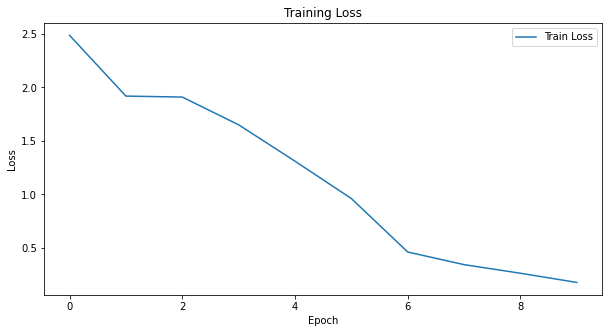

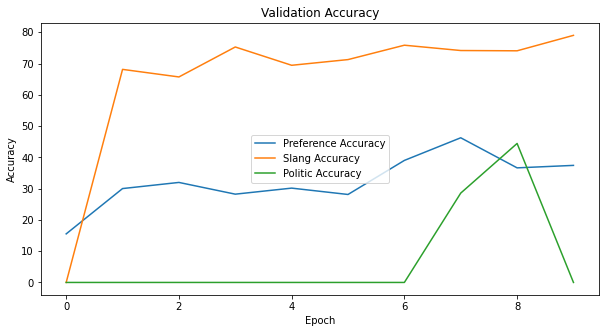

In [147]:
import matplotlib.pyplot as plt

# 학습 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# 검증 정확도 그래프
if config.do_eval_during_train:
    val_scores = list(zip(*val_accuracies))
    plt.figure(figsize=(10, 5))
    plt.plot(val_scores[0], label="Preference Accuracy")
    plt.plot(val_scores[1], label="Slang Accuracy")
    plt.plot(val_scores[2], label="Politic Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.show()

#### Test Dataset Inference

In [161]:
def inference(model, tokenizer, sentences, device):
    inference_result_1 = []
    inference_result_2 = []
    inference_result_3 = []

    model.eval()
    with torch.no_grad():
        for sentence in sentences:
            inputs = tokenizer.encode_plus(
                sentence, return_tensors="pt", padding="max_length", truncation=True, max_length=config.max_seq_length
            )
            inputs = {key: value.to(device) for key, value in inputs.items()}  # 입력을 GPU로 이동
            outputs = model(inputs)  # 모델 추론 수행
            outputs_1 = outputs[0]
            outputs_2 = outputs[1]
            outputs_3 = outputs[2]
            
            logits_1 = outputs[0].detach().cpu()
            logits_2 = outputs[1].detach().cpu()
            logits_3 = outputs[2].detach().cpu()
            threshold = 0.5
            predictions_1 = torch.argmax(logits_1, dim=-1)
            predictions_2 = logits_2.squeeze(1) >= threshold
            predictions_3 = logits_3.squeeze(1) >= threshold
            inference_result_1.append(predictions_1.item())  # 결과 리스트에 추가
            inference_result_2.append(predictions_2.item())
            inference_result_3.append(predictions_3.item())

    return inference_result_1, inference_result_2, inference_result_3

In [162]:
test_df = pd.read_csv("test_comments.csv")
sentences_to_infer = test_df["comment"].tolist()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inference_result_1, inference_result_2, inference_result_3 = inference(model, model.tokenizer, sentences_to_infer, device)

In [ ]:
test_df["선호도"] = inference_result_1
test_df["비속어"] = inference_result_2
test_df["정치"] = inference_result_3

In [ ]:
test_df

In [ ]:
output_csv_path = "inference_results.csv"
test_df.to_csv(output_csv_path, index=False)

In [ ]:
from transformers import AutoModelForPreTraining
model = AutoModel.from_pretrained("my_saved_model_directory")